# Empathic Art Project Data Preparation Notebook

## Introduction
This notebook details the proccess of preparing a dataset which consists of ".wav" audio files into a datasets of Spectrograms, Mel Spectrograms, LFCC or MFCC files.

## General Description of the Dataset 
The reason for the wide range of differing formats for the final dataset is the stage of the development at which this document is made. At this point, the team is trying out numerous different models to see which ones are the best fit for the project. At this point, the team decided to create the data preparation notebook as more of a pipeline with configurable constants, which impact the final look of the dataset. With the amount of different models, the final dataset changes in order to fit the needs of the model. 
The aspects of the dataset that change are:
- The sample rate of the soundfiles
- The length of the sound files
- The size of the final dataform
- Background noise removal from cleaner sound data.

## Imports

In [49]:
import pandas as pd

import torch
import torchaudio
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional

import torchvision

import torchaudio.functional as F
import torchaudio.transforms as T

from torch.utils.data.dataloader import Dataset, T_co

import noisereduce as nr

from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader

from sklearn import preprocessing

## Connecting the Google Drive

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


The Google Drive contains the dataset and the annotations. The paths to them are set here. The sample rate and amount of frames are also set here as constants. These also influence the length of the soundfiles, where the length in seconds is calculated by the formula T = NUM_FRAMES / SAMPLE_RATE.

## Setting the constants

In [50]:
ANNOTATIONS_DIR = "../../../data/reference_df.csv"
AUDIO_DIR = "../../../data/soundfiles"

SAMPLE_RATE = 44100
NUM_FRAMES = 88200

## The dataset class

In this class the main data proccessing happens. The class proccesses the data points by resampling them, cutting/padding them if a different length is needed and removing the noise from the file to improve the soundfile quality. The processing steps are applied only when the training requests an item from the datasets, saving a lot of disk space when creating different types of datasets.

In [51]:
class SpecgramDataset(Dataset):
    
    def __init__(self, annotations: str = ANNOTATIONS_DIR, audio_dir: str = AUDIO_DIR,  
                to_specgram = None, sample_rate: int = SAMPLE_RATE, num_frames: int = NUM_FRAMES) -> None:
        super().__init__()

        self.label_encoder = preprocessing.LabelEncoder()

        self.annotations = pd.read_csv(annotations)
        self.labels = self.label_encoder.fit_transform(self.annotations.emotion)

        self.audio_dir = audio_dir

        self.to_specgram = to_specgram

        self.sample_rate = sample_rate
        self.num_frames = num_frames
    
    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, index: int) -> T_co:
        label = self.labels[index]
        waveform, sr = torchaudio.load(f"{self.audio_dir}/{self.annotations.iloc[index].filename}")
        
        waveform = self._resample_if_necessary(waveform, sr)
        waveform = self._cut_if_necessary(waveform)
        waveform = self._right_pad_if_necessary(waveform)
        waveform = self._reduce_noise_if_necessary(waveform, sr)
        specgram = self.to_specgram(waveform)

        # incase of suround sound the shape of the tensor is [2, x, x]
        # basically the same array two times. So I just keep one of the two
        if int(specgram.shape[0]) == 2:
            specgram = specgram[0]
            specgram = specgram[None]

        # specgram = torchvision.transforms.Resize(size=(224, 224))(specgram)

        # normalize the image value
        return (specgram / 255.0), label

    def _cut_if_necessary(self, waveform: torch.Tensor) -> torch.Tensor:
        num_frames = waveform.shape[1]
        if num_frames > self.num_frames:
            waveform = waveform[:, :self.num_frames]
        return waveform

    def _right_pad_if_necessary(self, waveform: torch.Tensor) -> torch.Tensor:
        num_frames = waveform.shape[1]
        if num_frames < self.num_frames:
            missing_frames = self.num_frames - num_frames
            last_dim_padding = (0, missing_frames)
            waveform = nn.functional.pad(waveform, last_dim_padding)
        return waveform

    def _resample_if_necessary(self, waveform: torch.Tensor, sr: int) -> torch.Tensor:
        if self.sample_rate != sr:
            resampler = torchaudio.transforms.Resample(sr, self.sample_rate)
            waveform = resampler(waveform)
        return waveform

    def _reduce_noise_if_necessary(self, waveform: torch.Tensor, sr: int) -> torch.Tensor:
        waveform = nr.reduce_noise(y=waveform, y_noise=waveform,sr=sr)
        return torch.from_numpy(waveform)

Four different datasets are created here, each one based on a different form of presenting the data: Spectrogram, Mel Spectrogram, MFCC and LFCC.

In [52]:
# spectogram transform
spec_transform = T.Spectrogram(
    n_fft=1024,
    win_length=None,
    hop_length=512,
    center=True,
    pad_mode="reflect",
    power=2.0,
)
# spectogram dataset
spec_dataset = SpecgramDataset(to_specgram=spec_transform)

# mel spectogram transform
mel_transform = T.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=1024,
    win_length=None,
    hop_length=512,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm="slaney",
    onesided=True,
    n_mels=128,
    mel_scale="htk",
)
# mel spectogram dataset
mel_dataset = SpecgramDataset(to_specgram=mel_transform)


# mfcc tranform
mfcc_transform = T.MFCC(
    sample_rate=SAMPLE_RATE,
    n_mfcc=256,
    melkwargs={
        "n_fft": 2048,
        "n_mels": 256,
        "hop_length": 512,
        "mel_scale": "htk",
    },
)
# mfcc dataset
mfcc_dataset = SpecgramDataset(to_specgram=mfcc_transform)


# lfcc transform
lfcc_tranform = T.LFCC(
    sample_rate=SAMPLE_RATE,
    n_lfcc=256,
    speckwargs={
        "n_fft": 2048,
        "win_length": None,
        "hop_length": 512,
    },
)
# lfcc dataset
lfcc_dataset = SpecgramDataset(to_specgram=lfcc_tranform)


/home/michael/.local/share/virtualenvs/empathic-art-VdJ2KSTr/lib/python3.10/site-packages/torchaudio/functional/functional.py:571: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(
/home/michael/.local/share/virtualenvs/empathic-art-VdJ2KSTr/lib/python3.10/site-packages/torchaudio/functional/functional.py:571: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (1025) may be set too low.
  warnings.warn(


## Conclusion

As a conclusion for the data preparation, we have created a pipeline of sorts which can be used to generate different datasets at need, which will prove to be a great asset and tool to speed up the training process. While there is no definitive final dataset to present at this point, the versatility of the data proccessing step allows us to work on many different models efficiently.

In [53]:
specgram, label = spec_dataset[6]

In [54]:
specgram.shape

torch.Size([1, 513, 173])

In [55]:
specgram

tensor([[[3.0309e-05, 8.8175e-06, 1.0225e-05,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [1.5716e-05, 6.3010e-06, 4.4955e-06,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [7.4281e-06, 4.3089e-06, 2.0574e-06,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         ...,
         [3.2984e-14, 2.7211e-19, 1.0820e-17,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [3.2857e-14, 1.2245e-19, 1.6769e-18,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [3.2772e-14, 1.1021e-18, 5.4423e-20,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00]]])

In [56]:
import matplotlib.pyplot as plt
import librosa

def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

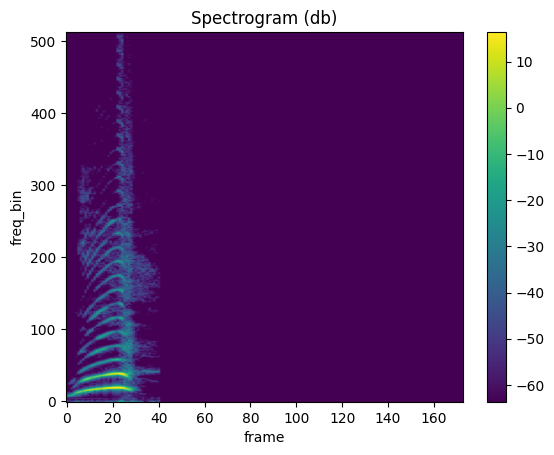

In [57]:
plot_spectrogram(specgram=specgram[0])

## Modelling

## .

In [58]:
class EmotionCNN(nn.Module):

    def __init__(self) -> None:
        super().__init__()

        self.network = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=5, padding=1, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(2, 2), # out: 32 x 128 x 128

            nn.Conv2d(32, 64, kernel_size=5, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=5, padding=1, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(2, 2), # out: 64 x 125 x 40

            nn.Dropout(p=.4),

            nn.Flatten(),

            nn.Linear(in_features=64 * 125 * 40, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=10),
        )

    def forward(self, xb: torch.Tensor):
        return self.network(xb)

    def train_step(self, batch):
        images, labels = batch
        out = self(images) # generate predictions
        loss = functional.cross_entropy(out, labels) # calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images) # generate predictgions
        loss = functional.cross_entropy(out, labels) # calculate loss
        acc = accuracy(out, labels) # calculate accuracy
        return {"val_loss": loss.detach(), "val_acc": acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()

        batch_accs = [x["val_acc"] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {"val_loss": epoch_loss.item(), "val_acc": epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print(f"Epoch {epoch}, train_loss: {result['train_loss']}, \
        val_loss: {result['val_loss']}, val_acc: {result['val_acc']}")


In [59]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [60]:
device = get_default_device()
device

device(type='cuda')

In [61]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [62]:
@torch.no_grad()
def evaluate(model: EmotionCNN, val_loader: DataLoader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [63]:
def fit(epochs, lr, model: EmotionCNN, train_loader, val_loader, opt_func = optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        train_losses = []

        for batch in train_loader:
            loss = model.train_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        result = evaluate(model, val_loader)
        result["train_loss"] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [64]:
train_num = int(len(spec_dataset) * .7)
val_num = len(spec_dataset) - train_num

train_ds, val_ds = random_split(
    dataset=spec_dataset, 
    lengths=[train_num, val_num], 
    generator=torch.Generator().manual_seed(42)
)

# train_num = int(len(lfcc_dataset) * .7)
# val_num = len(lfcc_dataset) - train_num

# train_ds, val_ds = random_split(
#     dataset=lfcc_dataset, 
#     lengths=[train_num, val_num], 
#     generator=torch.Generator().manual_seed(42)
# )

In [65]:
batch_size = 8

train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True, generator=torch.Generator().manual_seed(42))
val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)

In [66]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [67]:
model = to_device(EmotionCNN(), device)

In [68]:
import gc
gc.collect()

9010

In [69]:
torch.cuda.empty_cache()

In [47]:
simple_model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=5, padding=1, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(2, 2), # out: 32 x 128 x 128

            nn.Conv2d(32, 64, kernel_size=5, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=5, padding=1, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(2, 2), # out: 64 x 53 x 53
        ).to(device=device)

In [ ]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    out = simple_model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

In [70]:
history = fit(epochs=1, lr=.0001, model=model, train_loader=train_loader, val_loader=val_loader)

OutOfMemoryError: CUDA out of memory. Tried to allocate 626.00 MiB (GPU 0; 3.94 GiB total capacity; 2.73 GiB already allocated; 293.69 MiB free; 2.98 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
torch.save(model.state_dict(), "models/mfcc_model")